In [1]:
import pickle
import pandas as pd
import dalex as dx
import numpy as np
import random
import re

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

from multiprocessing import Pool

In [3]:
pickle_in = open("MEPS_xgb_model_final_v2_cat_vars_str.pickle", "rb")
reg_xgb = pickle.load(pickle_in);

In [4]:
def transform_target_log3(data, target_name):
    val = data[target_name].values
    return np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val])

def read_x_y(path, target_name):
    print(path)
    data = pd.read_csv(path)
    data[target_name] = transform_target_log3(data, target_name)
    X = data.drop(columns = target_name)
    y = data[target_name]
    return X, y


def get_categorical_features(data):
    num_unique = data.nunique()
    categorical_features = num_unique[num_unique <= 10].index.tolist()
    # Remove variables from categorical features list that can be treated as continuous
    for col in ["POVCAT15", "RTHLTH31", "MNHLTH31"]:
        categorical_features.remove(col)
    return categorical_features

path = "../../data/MEPS_data_preprocessed"
x_train, y_train = read_x_y(path + "_train.csv", "HEALTHEXP")
x_test, y_test = read_x_y(path + "_test.csv", "HEALTHEXP")


categorical_features = get_categorical_features(x_train)
numerical_features= [f for f in x_train.columns if f not in categorical_features]

for f in categorical_features:
    x_train[f] = x_train[f].astype("str")
    x_test[f] = x_test[f].astype("str")


../../data/MEPS_data_preprocessed_train.csv
../../data/MEPS_data_preprocessed_test.csv


In [5]:
# Creating dalex explainer
exp_xgb = dx.Explainer(reg_xgb, x_train, y_train, label = "MEPS", verbose=False)

The reset parameter is False but there is no n_features_in_ attribute. Is this estimator fitted?
The reset parameter is False but there is no n_features_in_ attribute. Is this estimator fitted?


### Creating list of variables describing diseases

In [6]:
dis_inx = [x for x in x_train.columns.tolist() if 'DX' in x]
print(dis_inx)

['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHOLDX', 'CANCERDX', 'DIABDX', 'ARTHDX', 'ASTHDX', 'ADHDADDX']


In [7]:
def plot_model_permutation_feature_importance(model, X_test, Y_test, model_name: str):
    result = permutation_importance(model, X_test, Y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
    return result

reg_xgb.fit(x_train, y_train)
res = plot_model_permutation_feature_importance(reg_xgb, x_test, y_test, "XGB ")

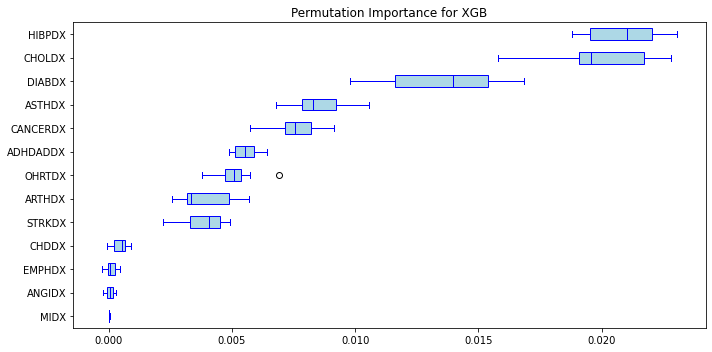

In [8]:
sorted_idx = res.importances_mean.argsort().tolist()
dis_var = []
for d in dis_inx:
    dis_var.append(x_test.columns.get_loc(d))
sorted_idx = [x for x in sorted_idx  if x in dis_var ]
fig, ax = plt.subplots(figsize=(10,5))
bp = ax.boxplot(res.importances[sorted_idx].T, patch_artist=True,
           vert=False, labels=x_test.columns[sorted_idx])
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='blue')
for patch in bp['boxes']:
    patch.set(facecolor='lightblue')
ax.set_title(f"Permutation Importance for XGB")
fig.tight_layout()
plt.savefig("06_avg_disesase_pif_values")

In [9]:
# Getting patients with a given disease
dis_dict = {x: [] for x in dis_inx}

def get_patients_with_diseases(dis_name: str):
    for index, row in x_train.iterrows():
        if row[dis_name] == '1':
            dis_dict[dis_name].append(index)

for disease in dis_inx:
    get_patients_with_diseases(disease)

In [10]:
# Creating random subset of patients for every disease
def get_random_subset_of_patients(size: int):
    dis_subset = {x: [] for x in dis_inx}
    for dis in dis_dict:
        dis_subset[dis] = random.sample(dis_dict[dis], min(size, len(dis_dict[dis])))
    return dis_subset

dis_dict_subset = get_random_subset_of_patients(50)

def get_distinct_patient_no(dis_with_patient: dict):
    list_patient_no = [no for key in dis_with_patient for no in dis_with_patient[key]]
    return list(set(list_patient_no))

patient_no = get_distinct_patient_no(dis_dict_subset)

In [ ]:
# Calculate shap results
df_res_sh = pd.DataFrame(columns=["Index", "Dis", "Sh"])

def get_shap_values(inx, df):
    sh_res = exp_xgb.predict_parts(pd.DataFrame(x_train.iloc[[inx]]), type='shap')
    for dis in dis_inx:
        if inx in dis_dict_subset[dis]:
            val = sh_res.result.loc[sh_res.result["variable"]== f"{dis} = 1"]['contribution'].mean()
            df = df.append({'Index': inx, 'Dis': dis, 'Sh': val}, ignore_index=True)
    return df

# with Pool(4) as p:
#     p.map(gef_shap_values, patient_no)

for no in patient_no:
    df_res_sh = get_shap_values(no, df_res_sh)

In [11]:
# Reading saved shap values from file

df_res_sh = pd.DataFrame(columns=["Index", "Dis", "Sh"])

with open('patients_shap_50.txt', 'r') as file:
    for line in file:
        if not re.match("^[0-9 ]+$", line):
            parts = re.split('\s|(?<!\d)[,.](?!\d)', line)
            if len(parts) >= 3:
                df_res_sh = df_res_sh.append({'Index': parts[0], 'Dis': parts[1], 'Sh': float(parts[2])}, ignore_index=True)

### Average shap value for each variable describing disease

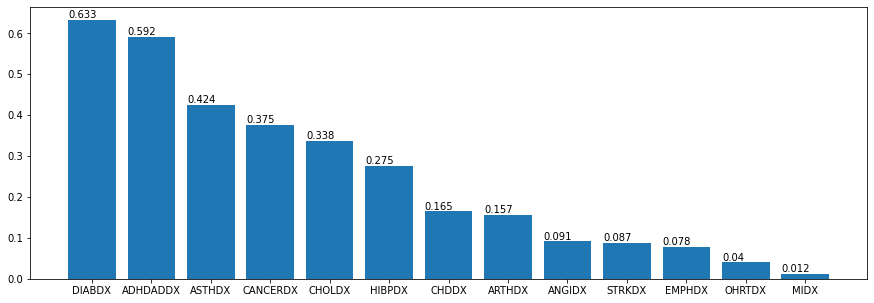

In [12]:
# Calculating mean shap value for each disease
df_sh_mean = { n : df_res_sh.loc[df_res_sh['Dis'] == n, 'Sh'].mean() for n in dis_inx }
d_view = [(k, v) for k, v in sorted(df_sh_mean.items(), key=lambda x: x[1], reverse=True)]

plt.figure(figsize=(15, 5))
bars = plt.bar(range(len(dis_inx)), [val for dis, val in d_view], align='center', width=0.8)
plt.xticks(range(len(dis_inx)), [dis for dis, val in d_view])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, round(yval, 3))
plt.show("06_avg_diseases_shap_values")

### Transforming the data input by deleting all disease related variables and created new column called POSVT (POSitiVe Tested) that is a weighted sum of positive disease diagnoses

In [13]:
# Adding column about positive diagnosed diseases with weighted values
fn = lambda row: sum([float(row[n]) * df_sh_mean[n] for n in dis_inx if int(row[n]) == 1])
col_train = x_train.apply(fn, axis=1)
col_test = x_test.apply(fn, axis=1)
x_train = x_train.assign(POSVT=col_train.values)
x_test = x_test.assign(POSVT=col_test.values)
numerical_features.append("POSVT")
# Removing columns about diseases
x_train =  x_train.drop(dis_inx, 1)
x_test = x_test.drop(dis_inx, 1)

In [14]:
cat_inx = categorical_features
for x in dis_inx:
    cat_inx.remove(x)

numerical_features.append("POSVT")

In [15]:
def print_model_results(y_train, y_pred_train, y_test, y_pred_test):
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    print("Training: \nRMSE: ", rmse_train, " | MAE: ", mean_absolute_error(y_train, y_pred_train), " | R^2: ", r2_score(y_train, y_pred_train), "\n")
    print("Test: \nRMSE: ", rmse_test, " | MAE: ", mean_absolute_error(y_test, y_pred_test), " | R^2: ", r2_score(y_test, y_pred_test), "\n")


### XGB model trained on newly created data set

In [16]:
categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

numerical_transformer = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, cat_inx),
        ("num", numerical_transformer, numerical_features)
    ]
)

regressor = GradientBoostingRegressor(n_estimators = 76,
                                    max_depth = 5,
                                    min_samples_split = 3,
                                    min_samples_leaf = 6,
                                    random_state = 123)

reg_xgb_2 = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])

reg_xgb_2.fit(x_train, y_train)


y_pred_train = reg_xgb_2.predict(x_train)
y_pred_test = reg_xgb_2.predict(x_test)
print("XGB")
print_model_results(y_train, y_pred_train, y_test, y_pred_test)

XGB
Training: 
RMSE:  2.0214149777806076  | MAE:  1.499952605147166  | R^2:  0.46410967040653717 

Test: 
RMSE:  2.164473490869821  | MAE:  1.6024235179904278  | R^2:  0.37751378269478897 



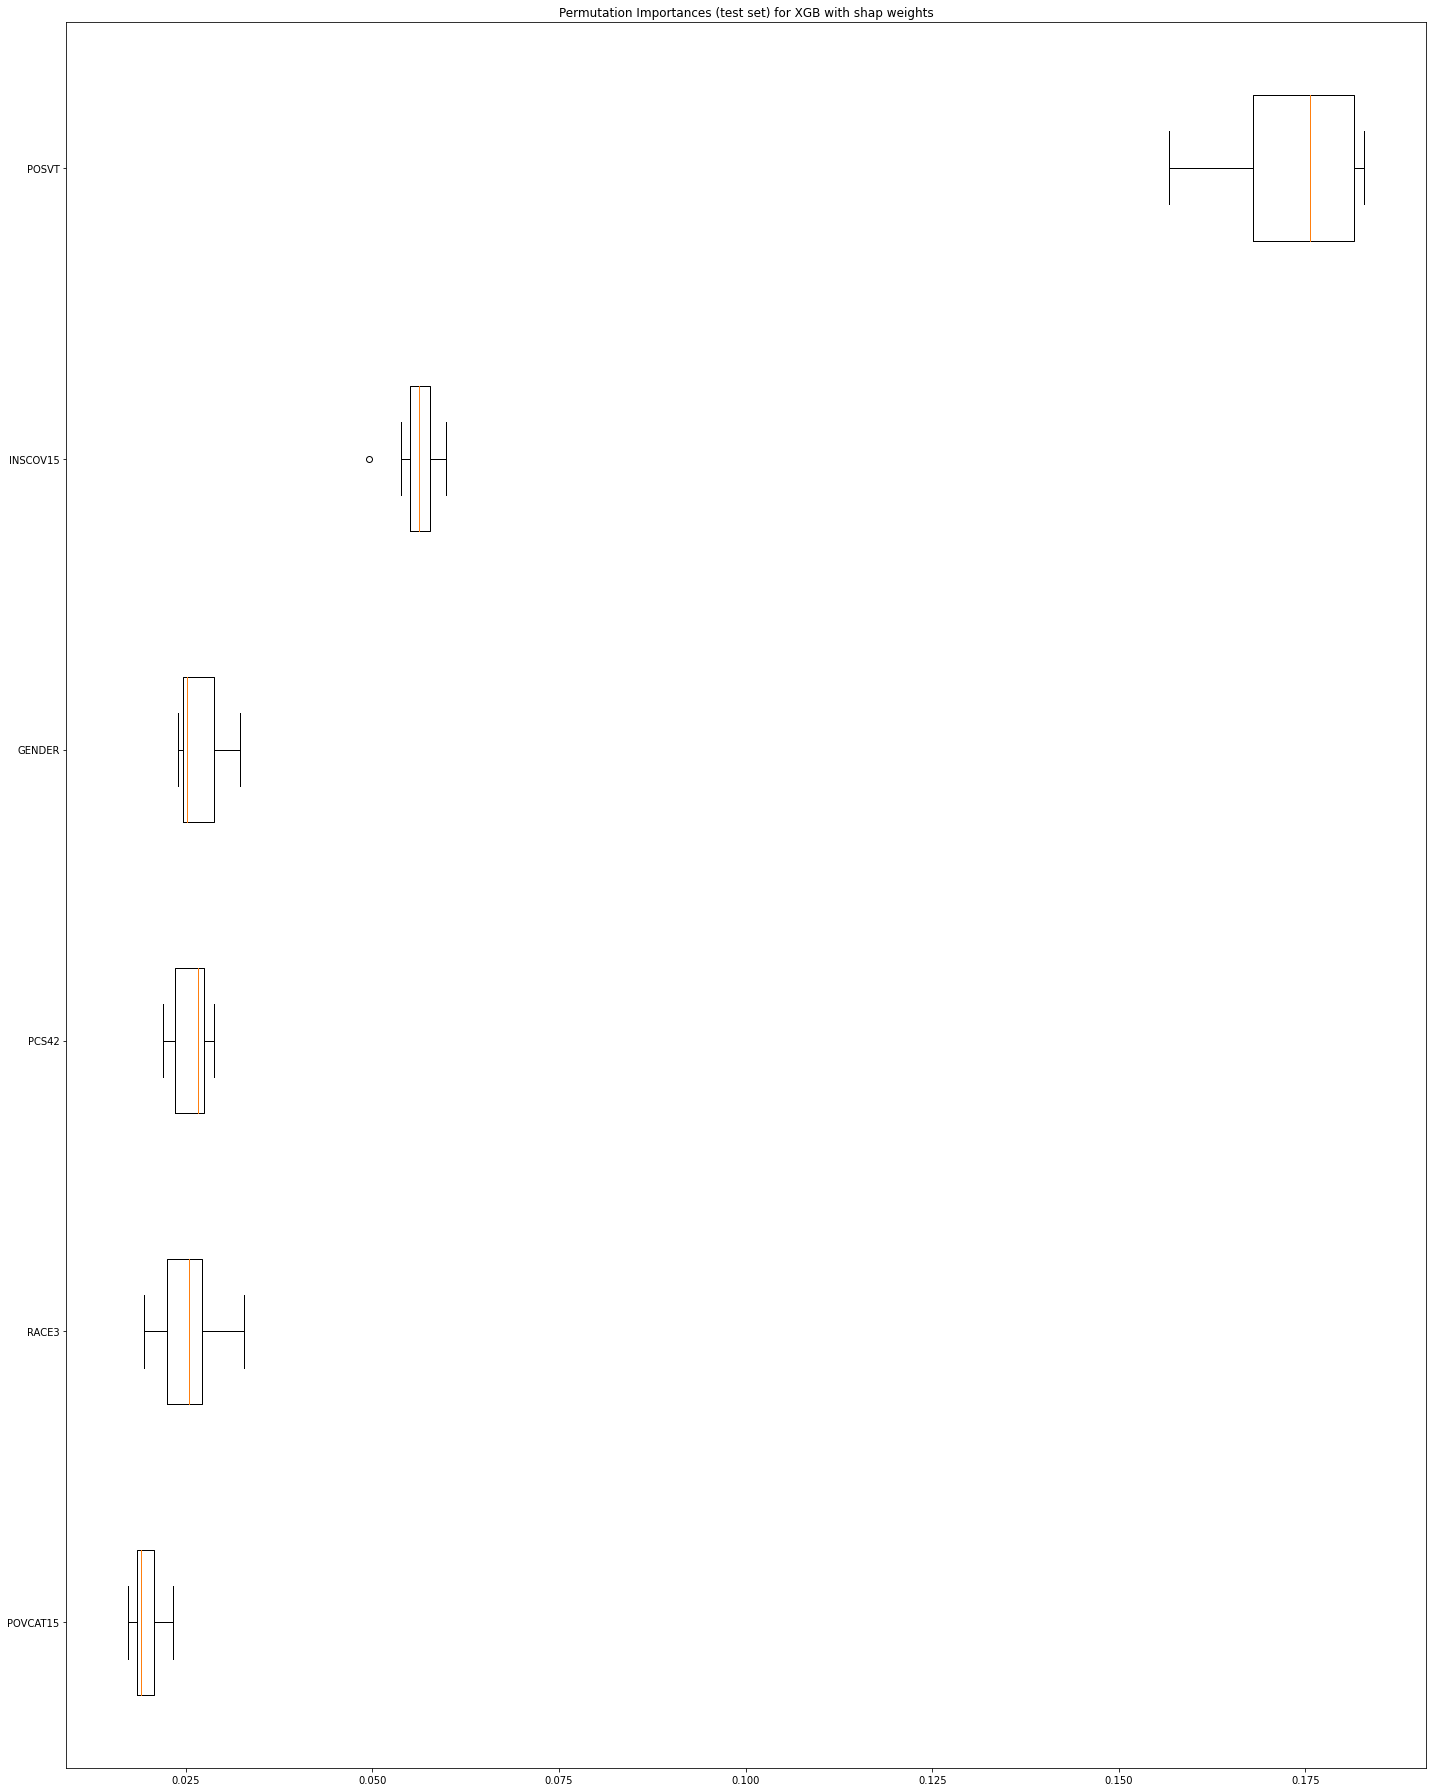

In [17]:
def plot_model_permutation_feature_importance(model, X_test, Y_test, model_name: str):
    result = permutation_importance(model, X_test, Y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    sorted_idx = sorted_idx[len(sorted_idx) - 6:]
    fig, ax = plt.subplots(figsize=(20,25))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title(f"Permutation Importances (test set) for {model_name}")
    fig.tight_layout()
    plt.savefig(model_name)

plot_model_permutation_feature_importance(reg_xgb_2, x_test, y_test, "XGB with shap weights")

### Ridge regression model on newly created dataset

In [18]:
# Linear model with the same  weights as in xgb model
param = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 30, 40, 50, 100, 150, 200]}

x_train_2 = StandardScaler().fit_transform(x_train)
x_test_2 = StandardScaler().fit_transform(x_test)

ridge = Ridge()
ridge_regressor = GridSearchCV(ridge, param, cv=5)
ridge_regressor.fit(x_train_2, y_train)
pred_rr_test = ridge_regressor.predict(x_test_2)
pred_rr_train = ridge_regressor.predict(x_train_2)
print("Ridge")
print_model_results(y_train, pred_rr_train, y_test, pred_rr_test)

Ridge
Training: 
RMSE:  2.27228977432158  | MAE:  1.7188136184013174  | R^2:  0.32283829531254704 

Test: 
RMSE:  2.2523752024218004  | MAE:  1.6952850671349031  | R^2:  0.3259274029288295 



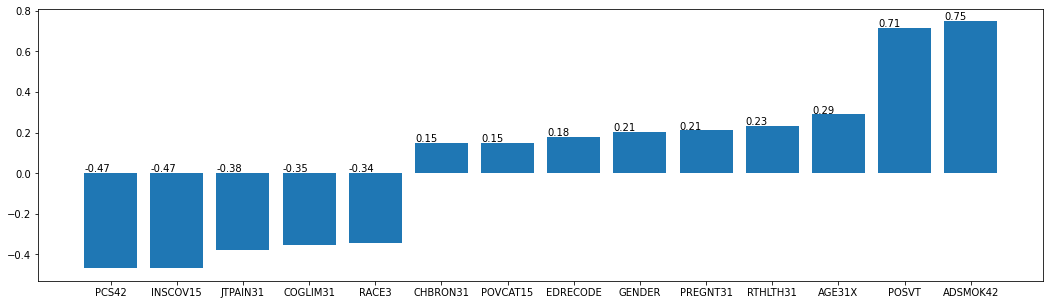

In [20]:
# Coefficients weight in rdige regression model
rr_coef = [(coef, name) for name, coef in zip(x_train.columns.tolist() , ridge_regressor.best_estimator_.coef_) if abs(coef) > 0.15]
rr_coef.sort()

plt.figure(figsize=(18, 5))
bars = plt.bar(range(len(rr_coef)), [val for val, coef in rr_coef], align='center', width=0.8)
plt.xticks(range(len(rr_coef)), [coef for val, coef in rr_coef])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), max(0, yval) + .007, round(yval, 2))
plt.savefig("06_rr_coef")